In [1]:
# =============================================================================
# IMPORTS
# =============================================================================

# DATA
import pandas as pd
import numpy as np

# VISUALS
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# =============================================================================
# GLOBAL PARAMETERS / ASSUMPTIONS
# =============================================================================

# These constants define the scenario for the Bayes / diagnostic test example.
# Feel free to change them to simulate different disease prevalence or test quality.

POPULATION = 1_000_000 # Total population
AFFLICTION_RATE = 0.01 # Share (probability) of people with disease

SENSITIVITY = 0.95 # (TPR) = P(test+ | sick) = 95%
SPECIFICITY = 0.95 # (TNR) = P(test− | healthy) = 95%


# Convenience shortcut for symmetric case (sens == spec).
# Useful when sweeping across a single "test quality" parameter.

SENS_SPEC = 0.95 # Assume sens=spec=0.95

In [3]:
# =============================================================================
# MAIN FUNCTION
# =============================================================================

def simulate_ppv_npv(population, affliction, sens, spec):
    """
    Monte-Carlo simulation of diagnostic test outcomes + PPV/NPV estimation.

    We simulate a population where:
      - a share 'affliction' is truly sick
      - the test has sensitivity 'sens' and specificity 'spec'

    Outputs:
      - Empirical sensitivity/specificity from the simulation (sanity check)
      - Empirical PPV and NPV from simulated outcomes
      - Analytical PPV computed via Bayes' theorem for comparison

    Notes:
      - This implementation is individual-level (builds a full DataFrame of size 'population').
        For very large populations this is slow / memory heavy; if needed we can switch to a
        counts-only simulation (TP/FP/FN/TN) without creating 1M rows.
      - Uses integer rounding via int(...). This introduces tiny bias; acceptable for large N.
    """

    
    # -------------------------------------------------------------------------
    # 1) Create 'population' table
    # -------------------------------------------------------------------------
    # Each row = one person
    # infected: ground truth (1 = sick, 0 = healthy)
    # test_positive: test result (1 = positive, 0 = negative)
    people = np.arange(1, population + 1, 1)
    people_df = pd.DataFrame(
        people,
        columns=['id']
    )
    people_df['infected'] = 0
    people_df['test_positive'] = 0

    
    # -------------------------------------------------------------------------
    # 2) Assign true infections (ground truth)
    # -------------------------------------------------------------------------
    n_infected = int(affliction * population) # number of truly sick people
    infected_ids = np.random.choice(
        people_df['id'],
        size=n_infected,
        replace=False
    )
    people_df.loc[people_df['id'].isin(infected_ids), 'infected'] = 1

    
    # -------------------------------------------------------------------------
    # 3) Simulate test positives among infected (True Positives via sensitivity)
    # -------------------------------------------------------------------------
    # sensitivity = P(test+ | sick)
    n_infection_confirmed = int(n_infected * sens)
    infection_confirmed_ids = np.random.choice(
        infected_ids,
        size=n_infection_confirmed,
        replace=False
    )
    people_df.loc[people_df['id'].isin(infection_confirmed_ids), 'test_positive'] = 1

    
    # -------------------------------------------------------------------------
    # 4) Simulate false positives among healthy (False Positives via 1-specificity)
    # -------------------------------------------------------------------------
    # specificity = P(test- | healthy)
    # so (1 - specificity) = P(test+ | healthy) = false positive rate
    healthy_ids = people_df.loc[people_df['infected'] == 0, 'id'].to_numpy()

    # sanity check: infected + healthy == population
    print('check (infected + healthy = population):', len(healthy_ids) + people_df['infected'].sum() == population)
    n_false_positive = int(len(healthy_ids) * (1 - spec))
    false_positive_ids = np.random.choice(
        healthy_ids,
        size=n_false_positive,
        replace=False
    )
    people_df.loc[people_df['id'].isin(false_positive_ids), 'test_positive'] = 1

    
    # -------------------------------------------------------------------------
    # 5) Sanity checks: empirical sensitivity/specificity from simulation
    # -------------------------------------------------------------------------
    # Empirical sensitivity = mean(test_positive) among infected
    print('Sensitivity:', people_df.loc[people_df['infected'] == 1, 'test_positive'].mean())  # sens
    
    # Empirical specificity = mean(test_negative) among healthy
    print('Specificity:', 1 - people_df.loc[people_df['infected'] == 0, 'test_positive'].mean())  # spec

    
    # -------------------------------------------------------------------------
    # 6) Compute PPV and NPV from simulated outcomes
    # -------------------------------------------------------------------------
    # TP = test+ & infected
    tp = ((people_df['test_positive'] == 1) & (people_df['infected'] == 1)).sum()
    
    # FP = test+ & healthy
    fp = ((people_df['test_positive'] == 1) & (people_df['infected'] == 0)).sum()
    
    # PPV = P(sick | test+)
    ppv = tp / (tp + fp)

    # NPV = P(healthy | test-)
    # Among test negatives, infected.mean() = P(infected | test-)
    # so 1 - that = P(healthy | test-)
    npv = (1 - people_df.loc[people_df['test_positive'] == 0, 'infected'].mean())
    print()
    print('Probability of being sick given a positive test (PPV):', ppv)
    print('Probability of being healthy given a negative test (NPV):', npv)


    # -------------------------------------------------------------------------
    # 7) Analytical PPV via Bayes (compare with simulation)
    # -------------------------------------------------------------------------
    # P(sick | test+) = P(test+ | sick)P(sick) / [P(test+ | sick)P(sick) + P(test+ | healthy)P(healthy)]
    bayes = (sens * affliction) / ((sens * affliction) + ((1-affliction)*(1-spec)))
    print()
    print('Bayesian probability:', bayes)


    # -------------------------------------------------------------------------
    # 8) Error report (simulation vs analytical)
    # -------------------------------------------------------------------------
    diff = ppv - bayes
    rel_err = (ppv - bayes) / bayes
    print(f"Diff = {diff:.10f}")
    print(f"Error = {rel_err:.10f}")


# Example run: symmetric test quality (sens == spec)
simulate_ppv_npv(POPULATION, AFFLICTION_RATE, SENS_SPEC, SENS_SPEC)

check (infected + healthy = population): True
Sensitivity: 0.95
Specificity: 0.95

Probability of being sick given a positive test (PPV): 0.16101694915254236
Probability of being healthy given a negative test (NPV): 0.9994686503719448

Bayesian probability: 0.16101694915254225
Diff = 0.0000000000
Error = 0.0000000000


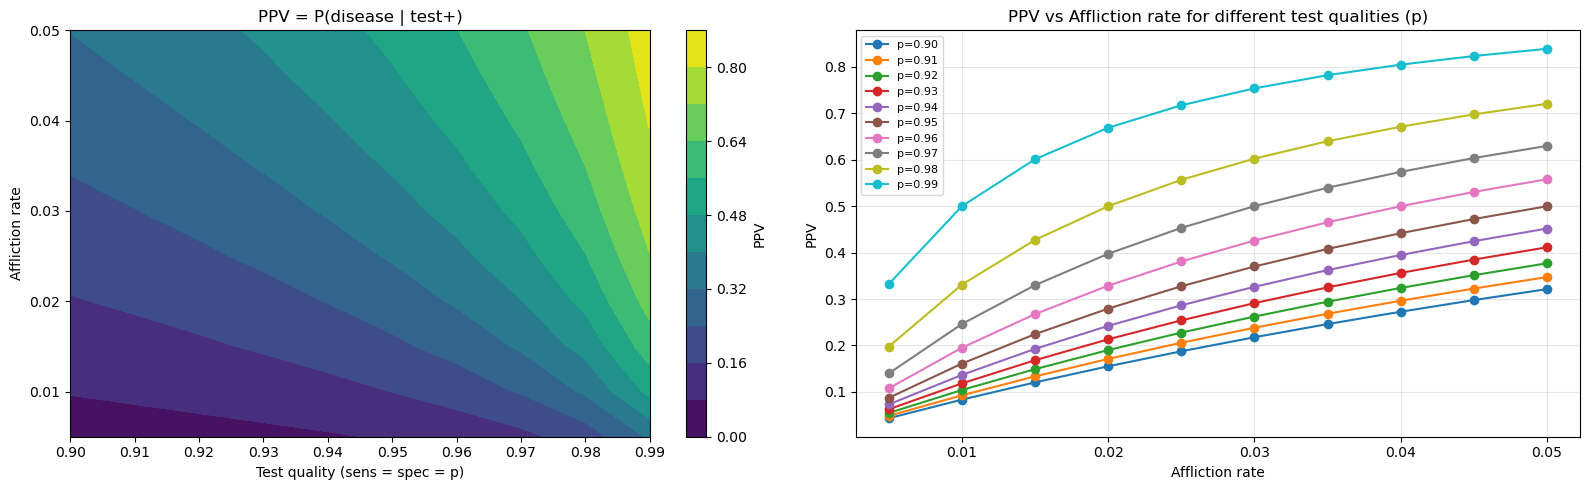

In [4]:
# =============================================================================
# BAYES PPV GRID + VISUALIZATION
# =============================================================================

# Goal:
#   Compute PPV = P(disease | test+) using Bayes theorem across a grid of:
#     - affliction (prevalence): P(disease)
#     - test quality p where sensitivity = specificity = p
#
# Output:
#   1) Contour/heatmap of PPV over (p, prevalence)
#   2) Line plots: PPV vs prevalence for each p


# -------------------------------------------------------------------------
# 1) Parameter grids (what we sweep over)
# -------------------------------------------------------------------------
# Test quality values (assume sens = spec = p)
# 0.90, 0.91, ... , 0.99
list_sens_spec = np.round(np.arange(0.9, 1, 0.01), 2)

# Disease prevalence values:
# 0.005, 0.010, ... , 0.050
list_affliction = np.arange(0.005, 0.055, 0.005)


# -------------------------------------------------------------------------
# 2) Bayes formula: PPV = P(disease | test+)
# -------------------------------------------------------------------------
def bayes_func(affliction, sens, spec):
    """
    Compute PPV (Positive Predictive Value) analytically using Bayes theorem.

    Parameters:
    affliction : float
        Prevalence of disease: P(disease)
    sens : float
        Sensitivity: P(test+ | disease)
    spec : float
        Specificity: P(test- | healthy)

    Returns:
    float
        PPV = P(disease | test+)
    """
    # Numerator: P(test+ | disease) * P(disease)
    # num = sens * affliction
    # Denominator: P(test+) = P(test+|disease)P(disease) + P(test+|healthy)P(healthy)
    # den = (sens * affliction) + ((1 - affliction) * (1 - spec))
    return (sens * affliction) / ((sens * affliction) + ((1-affliction)*(1-spec)))


# -------------------------------------------------------------------------
# 3) Build a results table for the full grid
# -------------------------------------------------------------------------
# Each row corresponds to one (affliction, p) pair and its PPV value.
results = []
for aff in list_affliction:
    for p in list_sens_spec:
        ppv = bayes_func(
            affliction=aff,
            sens=p,
            spec=p
        )
        results.append({'affliction': aff, 'p': p, 'ppv': bayes_func(aff, p, p)})

results_df = pd.DataFrame(results)


# -------------------------------------------------------------------------
# 4) Prepare matrix for contour plot
# -------------------------------------------------------------------------
# Pivot to 2D table: rows=affliction, cols=p, values=ppv
pivot = results_df.pivot(index='affliction', columns='p', values='ppv')

# Create meshgrid for contourf
X, Y = np.meshgrid(pivot.columns.values, pivot.index.values)
Z = pivot.values # PPV surface


# -------------------------------------------------------------------------
# 5) Plot: (left) contour / heatmap, (right) PPV curves vs prevalence
# -------------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# (A) Contour / heatmap of PPV over grid
cs = ax1.contourf(X, Y, Z, levels=12)
ax1.set_xlabel('Test quality (sens = spec = p)')
ax1.set_ylabel('Affliction rate')
ax1.set_title('PPV = P(disease | test+)')

cbar = fig.colorbar(cs, ax=ax1)
cbar.set_label('PPV')

# (B) Line plots: PPV vs prevalence for each p
# Each line = fixed p; x = prevalence; y = PPV
for p in list_sens_spec:
    tmp = results_df[results_df['p'] == p].sort_values('affliction')
    ax2.plot(tmp['affliction'], tmp['ppv'], marker='o', label=f"p={p:.2f}")

ax2.set_xlabel("Affliction rate")
ax2.set_ylabel('PPV')
ax2.set_title('PPV vs Affliction rate for different test qualities (p)')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()